In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import matplotlib.pyplot as plt
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/traffic-signs-preprocessed/mean_image_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/data5.pickle
/kaggle/input/traffic-signs-preprocessed/data4.pickle
/kaggle/input/traffic-signs-preprocessed/data7.pickle
/kaggle/input/traffic-signs-preprocessed/data8.pickle
/kaggle/input/traffic-signs-preprocessed/data1.pickle
/kaggle/input/traffic-signs-preprocessed/data3.pickle
/kaggle/input/traffic-signs-preprocessed/test.pickle
/kaggle/input/traffic-signs-preprocessed/mean_image_gray.pickle
/kaggle/input/traffic-signs-preprocessed/data6.pickle
/kaggle/input/traffic-signs-preprocessed/data0.pickle
/kaggle/input/traffic-signs-preprocessed/valid.pickle
/kaggle/input/traffic-signs-preprocessed/data2.pickle
/kaggle/input/traffic-signs-preprocessed/labels.pickle
/kaggle/input/traffic-signs-preprocessed/datasets_preparing.py
/kaggle/input/traffic-signs-preprocessed/std_gray.pickle
/kaggle/input/traffic-signs-preprocessed/std_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/label_na

## Read Data and plot mages

keys: dict_keys(['x_test', 'y_validation', 'x_validation', 'labels', 'x_train', 'y_test', 'y_train'])
train shape: (86989, 3, 32, 32)
test shape: (12630, 3, 32, 32)
validation shape: (4410, 3, 32, 32)


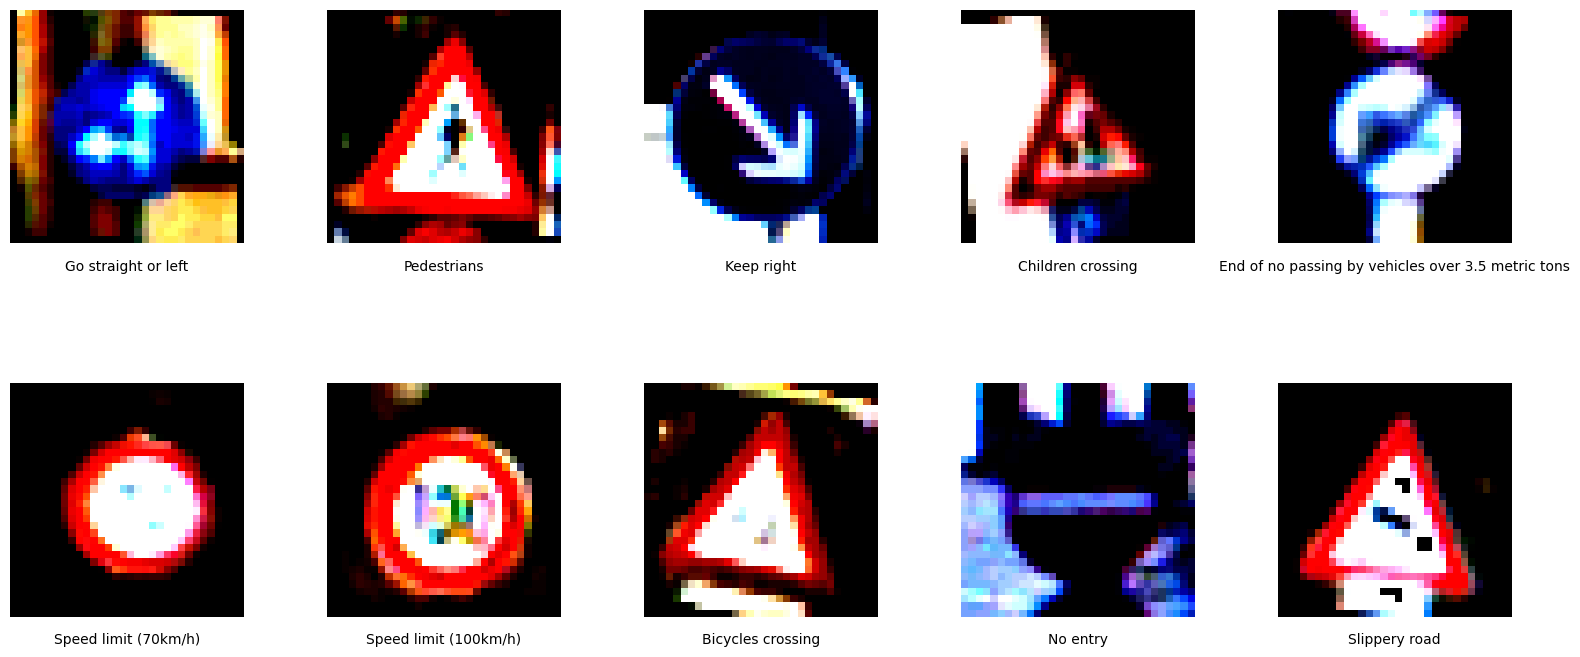

In [2]:
data = pd.read_pickle('/kaggle/input/traffic-signs-preprocessed/data0.pickle')
label = pd.read_csv('/kaggle/input/traffic-signs-preprocessed/label_names.csv')
print('keys:', data.keys())
print('train shape:', data['x_train'].shape)
print('test shape:', data['x_test'].shape)
print('validation shape:', data['x_validation'].shape)


# Display multiple images in a grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))


for i in range(10):
    img = np.transpose(data['x_train'][i], (1, 2, 0))
    class_id = data['y_train'][i]
    
    # Map class_id to corresponding ClassID from label DataFrame
    class_name = label[label['ClassId'] == class_id]['SignName'].values[0]

     # Normalize pixel values (standard normalization)
    img = (img - np.mean(img)) / np.std(img)
    
    # Display the image
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
    
    # Display the corresponding ClassID below the image
    axes[i // 5, i % 5].text(0.5, -0.1, f"{class_name}", 
                             horizontalalignment='center', verticalalignment='center', 
                             transform=axes[i // 5, i % 5].transAxes)

plt.tight_layout()


## Import relevant Libraries

In [3]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from scipy.sparse import csr_matrix

## Set hyperparameters

In [4]:
# parameters
LEARNING_RATE = 0.00001
BATCH_SIZE = 16
N_EPOCHS = 100
IMG_SIZE = 32
N_CLASSES = 43


## Transpose the input images to match the expected input shape



In [5]:
x_train_transposed = np.transpose(data['x_train'], (0, 2, 3, 1))
x_test_transposed = np.transpose(data['x_test'], (0, 2, 3, 1))
x_validation_transposed = np.transpose(data['x_validation'], (0, 2, 3, 1))

## Convert labels to one-hot encoding

In [6]:
encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = encoder.fit_transform(data['y_train'].reshape(-1, 1))
y_test_onehot = encoder.transform(data['y_test'].reshape(-1, 1))
y_validation_onehot = encoder.transform(data['y_validation'].reshape(-1, 1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Define a simple MLP with dropout layers


In [7]:
model = keras.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),
    layers.Dense(512, activation='leaky_relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='leaky_relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='leaky_relu'),
    layers.Dropout(0.1),
    layers.Dense(N_CLASSES, activation='softmax')
])


## Compile the model


In [8]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Define a callback to save the model weights


In [9]:
checkpoint_callback = callbacks.ModelCheckpoint(filepath='model_weights_leaky_relu3.h5',
                                                  save_weights_only=True,
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  mode='min',
                                                  verbose=1)

## Define early stopping callback

In [10]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1, restore_best_weights=True)

# Train the model with more epochs and early stopping


In [11]:
history = model.fit(x_train_transposed, y_train_onehot,
                    epochs=N_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_validation_transposed, y_validation_onehot),
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/100
5437/5437 [==============================] - ETA: 0s - loss: 25.9526 - accuracy: 0.0614
Epoch 1: val_loss improved from inf to 5.11233, saving model to model_weights_leaky_relu3.h5
5437/5437 [==============================] - 70s 13ms/step - loss: 25.9526 - accuracy: 0.0614 - val_loss: 5.1123 - val_accuracy: 0.1966
Epoch 2/100
5435/5437 [============================>.] - ETA: 0s - loss: 9.5218 - accuracy: 0.1357
Epoch 2: val_loss improved from 5.11233 to 3.17376, saving model to model_weights_leaky_relu3.h5
5437/5437 [==============================] - 68s 12ms/step - loss: 9.5207 - accuracy: 0.1357 - val_loss: 3.1738 - val_accuracy: 0.2871
Epoch 3/100
5433/5437 [============================>.] - ETA: 0s - loss: 6.1996 - accuracy: 0.1963
Epoch 3: val_loss improved from 3.17376 to 2.46900, saving model to model_weights_leaky_relu3.h5
5437/5437 [==============================] - 68s 13ms/step - loss: 6.1985 - accuracy: 0.1964 - val_loss: 2.4690 - val_accuracy: 0.3764
Epoch 4/1

## Plot model architecture


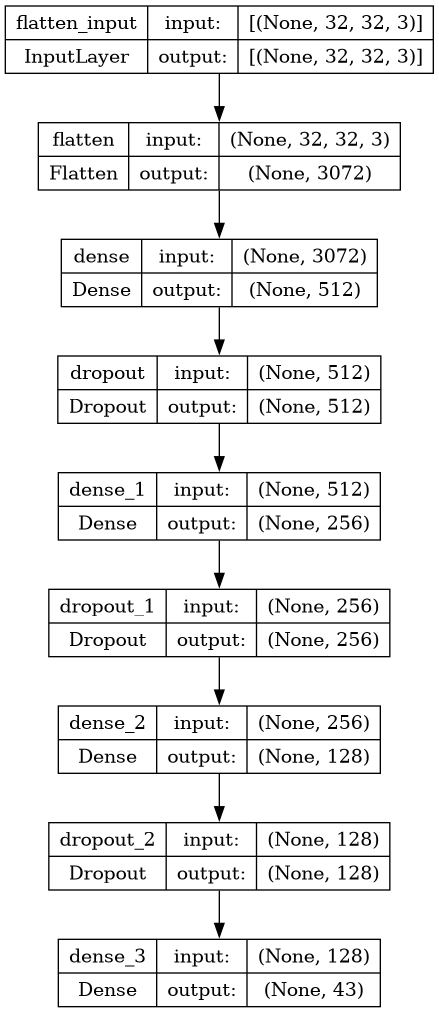

In [12]:
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)



## Plot training and validation losses over epochs



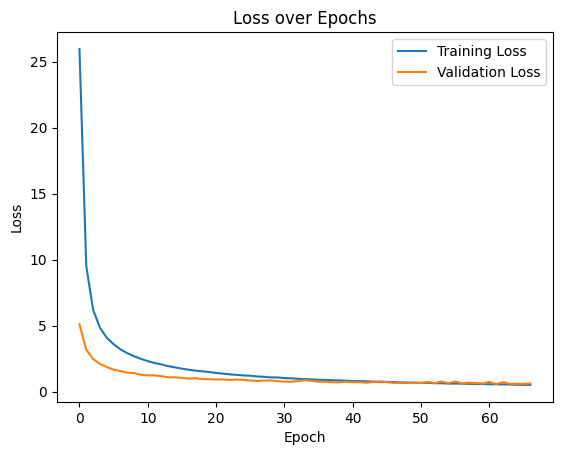

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing the model

395/395 [==============================] - 2s 4ms/step
(12630,)
Correct Predictions: 10774
Incorrect Predictions: 1856


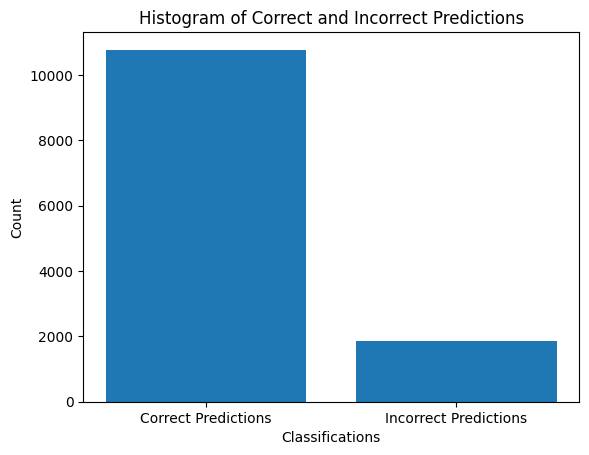

In [14]:
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

N_CLASSES = 43

# Load the model architecture (same as during training)
model = keras.Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(512, activation='leaky_relu'),
    Dropout(0.5),
    Dense(256, activation='leaky_relu'),
    Dropout(0.3),
    Dense(128, activation='leaky_relu'),
    Dropout(0.1),
    Dense(N_CLASSES, activation='softmax')
])

# Load the saved weights into the model
model.load_weights('/kaggle/working/model_weights_leaky_relu3.h5')

# Load test data
data = pd.read_pickle('/kaggle/input/traffic-signs-preprocessed/data0.pickle')
x_test_transposed = np.transpose(data['x_test'], (0, 2, 3, 1))

# Make predictions for the entire test dataset
predictions = model.predict(x_test_transposed)

# Decode the predictions
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes.shape)
true_classes = data['y_test']

# Count true and false predictions
correct_predictions = np.sum(predicted_classes == true_classes)
incorrect_predictions = len(true_classes) - correct_predictions

print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")
# Plot the histogram
plt.bar(['Correct Predictions', 'Incorrect Predictions'],
        [correct_predictions, incorrect_predictions])
plt.title('Histogram of Correct and Incorrect Predictions')
plt.xlabel('Classifications')
plt.ylabel('Count')
plt.show()
